In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import time
import torch
from torch_geometric.loader import DataLoader
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
%matplotlib notebook
import copy

import time
import torch
from torch_geometric.loader import DataLoader
from tqdm.notebook import trange, tqdm
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

seed = 0


import random 
import numpy as np
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
# print(torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('running on: ', device)
torch.set_num_threads(1)

from joblib import Parallel, delayed

from cutlass import *
from rbfConv import *
from tqdm.notebook import tqdm

from datautils import *
# from sphUtils import *
from lossFunctions import *

In [2]:

from plotting import *
plt.style.use('dark_background')
from tqdm.notebook import trange, tqdm

In [3]:
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [76]:
# debugPrint(7 / np.pi * inputData['fluidArea']  / attributes['support']**2)

In [44]:
def loadFrame(filename, frame, frameOffsets = [1], frameDistance = 1):
    inFile = h5py.File(filename)
    inGrp = inFile['simulationExport']['%05d' % frame]
#     debugPrint(inFile.attrs.keys())
    attributes = {
     'support': np.max(inGrp['fluidSupport'][:]),
     'targetNeighbors': inFile.attrs['targetNeighbors'],
     'restDensity': inFile.attrs['restDensity'],
     'dt': inGrp.attrs['dt'],
     'time': inGrp.attrs['time'],
     'radius': inFile.attrs['radius'],
     'area': inFile.attrs['radius'] **2 * np.pi,
    }
#     debugPrint(inGrp.attrs['timestep'])

    support = inFile.attrs['restDensity']
    targetNeighbors = inFile.attrs['targetNeighbors']
    restDensity = inFile.attrs['restDensity']
    dt = inFile.attrs['initialDt']

    inputData = {
        'fluidPosition': torch.from_numpy(inGrp['fluidPosition'][:]).type(torch.float32),
        'fluidVelocity': torch.from_numpy(inGrp['fluidVelocity'][:]).type(torch.float32),
        'fluidArea' : torch.from_numpy(inGrp['fluidArea'][:]).type(torch.float32),
        'fluidDensity' : torch.from_numpy(inGrp['fluidDensity'][:]).type(torch.float32),
        'fluidSupport' : torch.from_numpy(inGrp['fluidSupport'][:]).type(torch.float32),
        'fluidGravity' : torch.from_numpy(inGrp['fluidGravity'][:]).type(torch.float32) if 'fluidGravity' not in inFile.attrs else torch.from_numpy(inFile.attrs['fluidGravity']).type(torch.float32) * torch.ones(inGrp['fluidDensity'][:].shape[0])[:,None],
        'boundaryPosition': torch.from_numpy(inFile['boundaryInformation']['boundaryPosition'][:]).type(torch.float32),
        'boundaryNormal': torch.from_numpy(inFile['boundaryInformation']['boundaryNormals'][:]).type(torch.float32),
        'boundaryArea': torch.from_numpy(inFile['boundaryInformation']['boundaryArea'][:]).type(torch.float32),
        'boundaryVelocity': torch.from_numpy(inFile['boundaryInformation']['boundaryVelocity'][:]).type(torch.float32)
    }
    
    groundTruthData = []
    for i in frameOffsets:
        gtGrp = inFile['simulationExport']['%05d' % (frame + i * frameDistance)]
#         debugPrint((frame + i * frameDistance))
#         debugPrint(gtGrp.attrs['timestep'])
        gtData = {
            'fluidPosition'    : torch.from_numpy(gtGrp['fluidPosition'][:]),
            'fluidVelocity'    : torch.from_numpy(gtGrp['fluidVelocity'][:]),
            'fluidDensity'     : torch.from_numpy(gtGrp['fluidDensity'][:]),
    #         'fluidPressure'    : torch.from_numpy(gtGrp['fluidPressure'][:]),
    #         'boundaryDensity'  : torch.from_numpy(gtGrp['fluidDensity'][:]),
    #         'boundaryPressure' : torch.from_numpy(gtGrp['fluidPressure'][:]),
        }
        
        groundTruthData.append(torch.hstack((gtData['fluidPosition'].type(torch.float32), gtData['fluidVelocity'], gtData['fluidDensity'][:,None])))
        
    
    inFile.close()
    
    return attributes, inputData, groundTruthData

In [46]:

# attributes, inputData, groundTruthData = loadFrame(simulationFiles[0], 400, 1 + np.arange(1))

In [47]:
class RbfNet(torch.nn.Module):
    def __init__(self, fluidFeatures, boundaryFeatures, layers = [32,64,64,2], denseLayer = True, acitvation = 'relu'):
        super().__init__()
#         debugPrint(layers)
        
        self.features = copy.copy(layers)
#         debugPrint(fluidFeatures)
#         debugPrint(boundaryFeatures)
        self.convs = torch.nn.ModuleList()
        self.fcs = torch.nn.ModuleList()
        self.relu = getattr(nn.functional, 'relu')
#         debugPrint(fluidFeatures)

        self.convs.append(RbfConv(
            in_channels = fluidFeatures, out_channels = self.features[0],
            dim = 2, size = n,
            rbf = [rbf_x, rbf_y], periodic = False,
            dense_for_center = denseLayer, bias = False, activation = 'relu',
            batch_size = [forwardBatch, backwardBatch], windowFn = windowFn, normalizeWeights = False))
        
        self.convs.append(RbfConv(
            in_channels = boundaryFeatures, out_channels = self.features[0],
            dim = 2, size = n,
            rbf = [rbf_x, rbf_y], periodic = False,
            dense_for_center = False, bias = False, activation = 'relu',
            batch_size = [forwardBatch, backwardBatch], windowFn = None, normalizeWeights = False))
        
        self.fcs.append(nn.Linear(in_features=fluidFeatures,out_features= layers[0],bias=False))
        
        self.features[0] = self.features[0]
#         self.fcs.append(nn.Linear(in_features=96,out_features= 2,bias=False))
        
        for i, l in enumerate(layers[1:-1]):
#             debugPrint(layers[i])
#             debugPrint(layers[i+1])
            self.convs.append(RbfConv(
                in_channels = (3 * self.features[0]) if i == 0 else self.features[i], out_channels = layers[i+1],
                dim = 2, size = n,
                rbf = [rbf_x, rbf_y], periodic = False,
                dense_for_center = denseLayer, bias = False, activation = 'relu',
                batch_size = [forwardBatch, backwardBatch], windowFn = windowFn, normalizeWeights = False))
            self.fcs.append(nn.Linear(in_features=3 * layers[0] if i == 0 else layers[i],out_features=layers[i+1],bias=False))
            
        self.convs.append(RbfConv(
            in_channels = self.features[-2], out_channels = 2,
            dim = 2, size = n,
            rbf = [rbf_x, rbf_y], periodic = False,
            dense_for_center = denseLayer, bias = False, activation = None,
            batch_size = [forwardBatch, backwardBatch], windowFn = windowFn, normalizeWeights = False))
        self.fcs.append(nn.Linear(in_features=layers[-2],out_features=2,bias=False))


    def forward(self, \
                fluidPositions, boundaryPositions, \
                fluidFeatures, boundaryFeatures,\
                support, fluidBatches = None, boundaryBatches = None):
        fi, fj = radius(fluidPositions, fluidPositions, support, max_num_neighbors = 256, batch_x = fluidBatches, batch_y = fluidBatches)
        bf, bb = radius(boundaryPositions, fluidPositions, support, max_num_neighbors = 256, batch_x = boundaryBatches, batch_y = fluidBatches)
        
#         debugPrint(torch.max(bf))
#         debugPrint(torch.max(bb))
        
        boundaryEdgeIndex = torch.stack([bf, bb], dim = 0)
        boundaryEdgeLengths = (boundaryPositions[boundaryEdgeIndex[1]] - fluidPositions[boundaryEdgeIndex[0]])/support
#         debugPrint(torch.max(boundaryEdgeLengths))
        boundaryEdgeLengths = boundaryEdgeLengths.clamp(-1,1)
#         debugPrint(boundaryEdgeIndex.shape)        
#         debugPrint(boundaryEdgeLengths.shape)
        
        fluidEdgeIndex = torch.stack([fi, fj], dim = 0)
        fluidEdgeLengths = -(fluidPositions[fluidEdgeIndex[1]] - fluidPositions[fluidEdgeIndex[0]])/support
        fluidEdgeLengths = fluidEdgeLengths.clamp(-1,1)
#         debugPrint(fluidEdgeIndex.shape)        
#         debugPrint(fluidEdgeLengths.shape)
#         debugPrint(fluidFeatures.shape)
            
        linearOutput = self.relu(self.fcs[0](fluidFeatures))
#         debugPrint(linearOutput)
#         debugPrint(linearOutput.shape)
#         debugPrint(boundaryFeatures)
        boundaryConvolution = self.convs[1]((fluidFeatures, boundaryFeatures), boundaryEdgeIndex, boundaryEdgeLengths)
#         debugPrint(boundaryConvolution)
#         debugPrint(torch.max(boundaryConvolution))
#         debugPrint(boundaryConvolution.shape)
        fluidConvolution = self.convs[0]((fluidFeatures, fluidFeatures), fluidEdgeIndex, fluidEdgeLengths)
#         debugPrint(fluidConvolution)
#         debugPrint(fluidConvolution.shape)
        ans = torch.hstack((boundaryConvolution, fluidConvolution, boundaryConvolution))
#         debugPrint(ans.shape)
#         debugPrint(layer0out.shape)
#         return self.fcs[1](layer0out)
        
    
        layers = len(self.convs)
        for i in range(2,layers):
#             debugPrint(ans.shape)
            ansConv = self.convs[i]((ans, ans), fluidEdgeIndex, fluidEdgeLengths)
            ansDense = self.relu(self.fcs[i - 1](ans)) if i != layers - 1 else  self.fcs[i - 1](ans)
            
#             debugPrint(ansConv.shape)
#             debugPrint(ansDense.shape)
#             debugPrint(self.features[i-2])
#             debugPrint(self.features[i-1])
            if self.features[i-2] == self.features[i-1]:
                ans = ansConv + ansDense + ans
            else:
                ans = ansConv + ansDense
        return ans
            

In [94]:
class DensityNet(torch.nn.Module):
    def __init__(self, fluidFeatures, boundaryFeatures, layers = [32,64,64,2], denseLayer = True, acitvation = 'relu',
                coordinateMapping = 'polar', n = 8, m = 8, windowFn = None, rbf_x = 'linear', rbf_y = 'linear', batchSize = 32):
        super().__init__()
#         debugPrint(layers)
        
        self.features = copy.copy(layers)
#         debugPrint(fluidFeatures)
#         debugPrint(boundaryFeatures)
        self.convs = torch.nn.ModuleList()
        self.fcs = torch.nn.ModuleList()
        self.relu = getattr(nn.functional, 'relu')
#         debugPrint(fluidFeatures)

        self.convs.append(RbfConv(
            in_channels = fluidFeatures, out_channels = 1,
            dim = 2, size = [n,m],
            rbf = [rbf_x, rbf_y],
            linearLayer = False, biasOffset = False, feedThrough = False,
            preActivation = None, postActivation = None,
            coordinateMapping = coordinateMapping,
            batch_size = [batchSize, batchSize], windowFn = windowFn, normalizeWeights = False))
        
        self.convs.append(RbfConv(
            in_channels = boundaryFeatures, out_channels = 1,
            dim = 2, size = [n,m],
            rbf = [rbf_x, rbf_y], 
            linearLayer = False, biasOffset = False, feedThrough = False,
            preActivation = None, postActivation = None,
            coordinateMapping = coordinateMapping,
            batch_size = [batchSize, batchSize], windowFn = windowFn, normalizeWeights = False))
        

    def forward(self, \
                fluidPositions, boundaryPositions, \
                fluidFeatures, boundaryFeatures,\
                support, fluidBatches = None, boundaryBatches = None):
        fi, fj = radius(fluidPositions, fluidPositions, support, max_num_neighbors = 256, batch_x = fluidBatches, batch_y = fluidBatches)
        bf, bb = radius(boundaryPositions, fluidPositions, support, max_num_neighbors = 256, batch_x = boundaryBatches, batch_y = fluidBatches)
        
        i, ni = torch.unique(fi, return_counts = True)
        b, nb = torch.unique(bf, return_counts = True)
        ni[i[b]] += nb

        self.li = torch.exp(-1 / np.float32(attributes['targetNeighbors']) * ni)
        
        boundaryEdgeIndex = torch.stack([bf, bb], dim = 0)
        boundaryEdgeLengths = (boundaryPositions[boundaryEdgeIndex[1]] - fluidPositions[boundaryEdgeIndex[0]])/support
        boundaryEdgeLengths = boundaryEdgeLengths.clamp(-1,1)
            
        fluidEdgeIndex = torch.stack([fi, fj], dim = 0)
        fluidEdgeLengths = (fluidPositions[fluidEdgeIndex[1]] - fluidPositions[fluidEdgeIndex[0]])/support
#         debugPrint(torch.min(fluidEdgeLengths))
#         debugPrint(torch.max(fluidEdgeLengths))
        fluidEdgeLengths = fluidEdgeLengths.clamp(-1,1)
        
#         debugPrint(fluidFeatures)
#         debugPrint(boundaryFeatures)
        
        boundaryConvolution = self.convs[1]((fluidFeatures, boundaryFeatures), boundaryEdgeIndex, boundaryEdgeLengths)
#         debugPrint(fluidPositions)
#         debugPrint(fluidFeatures)
#         debugPrint(fluidEdgeIndex)
#         debugPrint(fluidEdgeLengths)
        fluidConvolution = self.convs[0]((fluidFeatures, fluidFeatures), fluidEdgeIndex, fluidEdgeLengths)
#         debugPrint(fluidConvolution[:,0][:8])
#         debugPrint(boundaryConvolution[:,0][:8])
        # return fluidConvolution
        return fluidConvolution  + boundaryConvolution

In [95]:
def constructFluidFeatures(inputData):
    fluidFeatures = torch.hstack(\
                (torch.ones(inputData['fluidArea'].shape[0]).type(torch.float32).unsqueeze(dim=1), \
                 inputData['fluidVelocity'].type(torch.float32), 
                 inputData['fluidGravity'].type(torch.float32)))

    fluidFeatures = torch.ones(inputData['fluidArea'].shape[0]).type(torch.float32).unsqueeze(dim=1)
    fluidFeatures[:,0] *= 7 / np.pi * inputData['fluidArea']  / attributes['support']**2
#     fluidFeatures = inputData['fluidArea'].type(torch.float32).unsqueeze(dim=1)
    
    boundaryFeatures = inputData['boundaryNormal'].type(torch.float32)
    boundaryFeatures = torch.ones(inputData['boundaryNormal'].shape[0]).type(torch.float32).unsqueeze(dim=1)
    boundaryFeatures[:,0] *=  7 / np.pi * inputData['boundaryArea']  / attributes['support']**2
    
    return inputData['fluidPosition'].type(torch.float32), inputData['boundaryPosition'].type(torch.float32), fluidFeatures, boundaryFeatures

In [503]:
#  semi implicit euler, network predicts velocity update
def integrateState(inputPositions, inputVelocities, modelOutput, dt):
    predictedVelocity = modelOutput #inputVelocities +  modelOutput 
    predictedPosition = inputPositions + attributes['dt'] * predictedVelocity
    
    return predictedPosition, predictedVelocity
# velocity loss
def computeLoss(predictedPosition, predictedVelocity, groundTruth, modelOutput):
#     debugPrint(modelOutput.shape)
#     debugPrint(groundTruth.shape)
#     return torch.sqrt((modelOutput - groundTruth[:,-1:].to(device))**2)
    return torch.abs(modelOutput - groundTruth[:,-1:].to(device))
    return torch.linalg.norm(groundTruth[:,2:] - predictedVelocity, dim = 1)

def loadData(dataset, index, unroll = 1):
    fileName, frameIndex, maxRollouts = dataset[index]

    attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 1 + np.arange(unroll), frameDistance = frameDistance)
    fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(inputData)
    
    return attributes, fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, groundTruthData


def loadBatch(train_ds, bdata, unroll = 1):
    fluidPositions = []
    boundaryPositions = []
    fluidFeatures = []
    boundaryFeatures = []
    fluidBatchIndices = []
    boundaryBatchIndices = []
    groundTruths = []
    for i in range(unroll):
        groundTruths.append([])
    
    for i,b in enumerate(bdata):
#         debugPrint(i)
#         debugPrint(b)
        attribute, fluidPosition, boundaryPosition, fluidFeature, boundaryFeature, groundTruth = loadData(train_ds, b, unroll = unroll)     
#         debugPrint(groundTruth)
        fluidPositions.append(fluidPosition)
#         debugPrint(fluidPositions)
        boundaryPositions.append(boundaryPosition)
        fluidFeatures.append(fluidFeature)
        boundaryFeatures.append(boundaryFeature)
        
        batchIndex = torch.ones(fluidPosition.shape[0], device = device) * i
        fluidBatchIndices.append(batchIndex)
        
        batchIndex = torch.ones(boundaryPosition.shape[0], device = device) * i
        boundaryBatchIndices.append(batchIndex)
        for u in range(unroll):
            groundTruths[u].append(groundTruth[u])
        
    fluidPositions = torch.vstack(fluidPositions)
    boundaryPositions = torch.vstack(boundaryPositions)
    fluidFeatures = torch.vstack(fluidFeatures)
    boundaryFeatures = torch.vstack(boundaryFeatures)
    fluidBatchIndices = torch.hstack(fluidBatchIndices)
    boundaryBatchIndices = torch.hstack(boundaryBatchIndices)
    for u in range(unroll):
        groundTruths[u] = torch.vstack(groundTruths[u])
    
    return fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, fluidBatchIndices, boundaryBatchIndices, groundTruths
    
def processBatch(train_ds, bdata, unroll):
    fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures, fluidBatches, boundaryBatches, groundTruths = loadBatch(train_ds, bdata, unroll)    
    
    predictedPositions = fluidPositions.to(device)
    predictedVelocity = fluidFeatures[:,1:3].to(device)
    
    unrolledLosses = []
    bLosses = []
#     debugPrint(bdata)
    boundaryPositions = boundaryPositions.to(device)
    fluidFeatures = fluidFeatures.to(device)
    boundaryFeatures = boundaryFeatures.to(device)
    
#     debugPrint(bdata)
#     debugPrint(predictedPosition)
    
    ls = []
    
    for u in range(1):
        predictions = model(predictedPositions, boundaryPositions, fluidFeatures, boundaryFeatures, attributes['support'], fluidBatches, boundaryBatches)

        predictedPositions, predictedVelocities = integrateState(predictedPositions, predictedVelocity, predictions, attributes['dt'])
        
        fluidFeatures = torch.hstack((fluidFeatures[:,0][:,None], predictedVelocity, fluidFeatures[:,3:]))
#         fluidFeatures[:,1:3] = predictedVelocity

#         debugPrint(prediction.shape)
#         debugPrint(groundTruths[0].shape)
#         loss = model.li * (predictions - groundTruths[0][:,-1:].to(device)) ** 0.5
#         debugPrint(model.li)
#         loss = computeLoss(predictedPositions, predictedVelocities, groundTruths[u].to(device), predictions)
#         loss = model.li * torch.sqrt(computeLoss(predictedPositions, predictedVelocities, groundTruths[u].to(device), predictions))
#         loss = model.li * computeLoss(predictedPositions, predictedVelocities, groundTruths[u].to(device), predictions)
        loss = computeLoss(predictedPositions, predictedVelocities, groundTruths[u].to(device), predictions)
#         p = 8
#         debugPrint(loss[:p,0].detach().cpu().numpy())
#         debugPrint(predictions[:p,0].detach().cpu().numpy())
#         debugPrint(groundTruths[0][:,-1:][:p,0].detach().cpu().numpy())
#         print('----------------------')
        ls.append(torch.mean(loss))
        batchedLoss = []
#         debugPrint(fluidBatches)
        for i in range(len(bdata)):
            L = loss[fluidBatches == i]
#             debugPrint(L)
            Lterms = (torch.mean(L), torch.max(torch.abs(L)), torch.min(torch.abs(L)), torch.std(L))
            
            
            batchedLoss.append(torch.hstack(Lterms))
        batchedLoss = torch.vstack(batchedLoss).unsqueeze(0)
#         debugPrint(batchedLoss.shape)
        batchLoss = torch.mean(loss)# + torch.max(torch.abs(loss))
        bLosses.append(batchedLoss)
        unrolledLosses.append(batchLoss)
        
#     debugPrint(bLosses)
#     debugPrint(torch.cat(bLosses))
#     debugPrint(bLosses.shape)
#     debugPrint(bLosses)
    
#     return torch.mean(torch.hstack(ls))
    
    bLosses = torch.vstack(bLosses)
    maxLosses = torch.max(bLosses[:,:,1], dim = 0)[0]
    minLosses = torch.min(bLosses[:,:,2], dim = 0)[0]
    meanLosses = torch.mean(bLosses[:,:,0], dim = 0)
    stdLosses = torch.mean(bLosses[:,:,3], dim = 0)
    
    
    del predictedPositions, predictedVelocities, boundaryPositions, fluidFeatures, boundaryFeatures, fluidBatches, boundaryBatches
    
    bLosses = bLosses.transpose(0,1)
    
    return bLosses, meanLosses, minLosses, maxLosses, stdLosses



In [504]:
basePath = '../export'
basePath = os.path.expanduser(basePath)

simulationFiles = [basePath + '/' + f for f in os.listdir(basePath) if f.endswith('.hdf5')]
for i, c in enumerate(simulationFiles):
    print(i ,c)
    
simulationFiles  = [simulationFiles[0]]

training = []
validation = []
testing = []


for s in simulationFiles:    
    _, train, valid, test = splitFile(s, split = True, limitRollOut = False, skip = 0, cutoff = 800)
    training.append((s,train))
    validation.append((s,valid))
    testing.append((s,test))

0 ../export/dambreak - 2023-02-13_12-54-39.hdf5
1 ../export/dambreak - 2023-02-13_11-57-41.hdf5
2 ../export/dambreak - 2023-02-15_10-02-41.hdf5


In [600]:
batch_size = 4

train_ds = datasetLoader(training)
train_dataloader = DataLoader(train_ds, shuffle=True, batch_size = batch_size).batch_sampler

validation_ds = datasetLoader(validation)
validation_dataloader = DataLoader(validation_ds, shuffle=True, batch_size = batch_size).batch_sampler

fileName, frameIndex, maxRollout = train_ds[len(train_ds)//2]
# frameIndex = 750
attributes, inputData, groundTruthData = loadFrame(simulationFiles[0], 400, 1 + np.arange(1))
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(inputData)

debugPrint(fluidFeatures.shape)


n = 8
m = 8
coordinateMapping = 'polar'
windowFn = lambda r: torch.clamp(torch.pow(1. - r, 4) * (1.0 + 4.0 * r), min = 0)
rbf_x = 'linear'
rbf_y = 'linear'
initialLR = 1e-2
maxRollOut = 10
epochs = 25
frameDistance = 0




model = DensityNet(fluidFeatures.shape[1], boundaryFeatures.shape[1], coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = 64)



lr = initialLR
optimizer = Adam(model.parameters(), lr=lr)
model = model.to(device)

# torch.max(getLoss(simulationFiles[0], state['timestep'], prediction, config, state, loss = 'preShift'))

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters', count_parameters(model))

# with torch.no_grad():
#     model.convs[0].weight[:] = torch.normal(mean = torch.ones(model.convs[0].weight.shape),  std = 1e-4)
#     model.convs[1].weight[:] = torch.normal(mean = torch.ones(model.convs[1].weight.shape),  std = 1e-4)

        
optimizer.zero_grad()
model.train()

hyperParameterDict = {}
hyperParameterDict['n'] = n
hyperParameterDict['m'] = m
hyperParameterDict['coordinateMapping'] = coordinateMapping
hyperParameterDict['rbf_x'] = rbf_x
hyperParameterDict['rbf_y'] = rbf_y
hyperParameterDict['windowFunction'] = 'yes' if windowFn is not None else 'no'
hyperParameterDict['initialLR'] = initialLR
hyperParameterDict['maxRollOut'] = maxRollOut
hyperParameterDict['epochs'] = epochs
hyperParameterDict['frameDistance'] = frameDistance
hyperParameterDict['parameters'] =  count_parameters(model)

debugPrint(hyperParameterDict)


fluidFeatures.shape [Size] = torch.Size([802, 1])
Number of parameters 128
hyperParameterDict [dict] = {'n': 8, 'm': 8, 'coordinateMapping': 'polar', 'rbf_x': 'linear', 'rbf_y': 'linear', 'windowFunction': 'yes', 'initialLR': 0.01, 'maxRollOut': 10, 'epochs': 25, 'frameDistance': 0, 'parameters': 128}


In [601]:
# debugPrint(fluidFeatures)

In [602]:

# fileName, frameIndex, maxRollout = train_ds[0]
# # frameIndex = 750
# attributes, inputData, groundTruthData = loadFrame(simulationFiles[0], 400, 1 + np.arange(1))
# fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(inputData)

# prediction = model(fluidPositions.to(device), boundaryPositions.to(device), fluidFeatures.to(device), boundaryFeatures.to(device), attributes['support'], None, None)

# # debugPrint(fluidFeatures)
# # debugPrint(boundaryFeatures)

# debugPrint(prediction.shape)
# # debugPrint(prediction[:,0] - groundTruthData[0][:,-1].to(device))

# debugPrint(prediction[:,0][:8])
# debugPrint(groundTruthData[0][:,-1][:8])

# debugPrint(prediction[:,0][:8] - groundTruthData[0][:,-1][:8].to(device))

# debugPrint(torch.mean(prediction[:,0] - groundTruthData[0][:,-1].to(device)))

In [603]:
# windowFn = lambda r: torch.pow(1. - r, 4) * (1.0 + 4.0 * r)

# fi, fj = radius(fluidPositions, fluidPositions, attributes['support'], max_num_neighbors = 256, batch_x = None, batch_y = None)
# bf, bb = radius(boundaryPositions, fluidPositions,  attributes['support'], max_num_neighbors = 256, batch_x = None, batch_y = None)

# #         debugPrint(torch.max(bf))
# #         debugPrint(torch.max(bb))

# boundaryEdgeIndex = torch.stack([bf, bb], dim = 0)
# boundaryEdgeLengths = (boundaryPositions[boundaryEdgeIndex[1]] - fluidPositions[boundaryEdgeIndex[0]])/attributes['support']
# #         debugPrint(torch.max(boundaryEdgeLengths))
# boundaryEdgeLengths = boundaryEdgeLengths.clamp(-1,1)
# #         debugPrint(boundaryEdgeIndex.shape)        
# #         debugPrint(boundaryEdgeLengths.shape)

# fluidEdgeIndex = torch.stack([fi, fj], dim = 0)
# fluidEdgeLengths = -(fluidPositions[fluidEdgeIndex[1]] - fluidPositions[fluidEdgeIndex[0]])/attributes['support']
# # fluidEdgeLengths = fluidEdgeLengths.clamp(-1,1)


# windows = windowFn(torch.linalg.norm(fluidEdgeLengths, dim = 1))
# fac =  7 / np.pi * inputData['fluidArea']  / attributes['support']**2
# wi = fac * scatter(windows, fi, dim = 0, dim_size = fluidPositions.shape[0], reduce='sum')

# windows2 = windowFn(torch.linalg.norm(boundaryEdgeLengths, dim = 1))
# fac =  7 / np.pi * inputData['boundaryArea']  / attributes['support']**2
# # debugPrint(fac)
# wi += scatter(fac[bb] * windows2, bf, dim = 0, dim_size = fluidPositions.shape[0], reduce='sum')

In [604]:
# fileName, frameIndex, maxRollout = train_ds[len(train_ds)//2]
# # frameIndex = 750
# attributes, inputData, groundTruthData = loadFrame(simulationFiles[0], 400, 1 + np.arange(1))
# fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(inputData)
# # modelOutput = model(fluidPositions.to(device), boundaryPositions.to(device), fluidFeatures.to(device), boundaryFeatures.to(device), attributes['support'], None, None)

# # debugPrint(modelOutput.shape)

# positions = inputData['fluidPosition'].to(device)

# fig, axis = plt.subplots(1, 1, figsize=(5,5), sharex = False, sharey = False, squeeze = False)

# axis[0,0].set_title('prediction')
# x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
# y = inputData['fluidPosition'][:,1].detach().cpu().numpy()
# v = (wi - groundTruthData[0][:,-1]).detach().cpu().numpy()
# # debugPrint(v)
# predSC = axis[0,0].scatter(x,y,c = v,s=2)
# axis[0,0].axis('equal')
# axis[0,0].set_xlim(-2.5,2.5)
# axis[0,0].set_ylim(-2.5,2.5)
# axis[0,0].axvline(-2)
# axis[0,0].axvline(2)
# axis[0,0].axhline(-2)
# axis[0,0].axhline(2)
# ax1_divider = make_axes_locatable(axis[0,0])
# cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")

# predCbar = fig.colorbar(predSC, cax=cax1,orientation='horizontal')
# predCbar.ax.tick_params(labelsize=8) 


In [605]:
def constructFluidFeatures(inputData):
    fluidFeatures = torch.hstack(\
                (torch.ones(inputData['fluidArea'].shape[0]).type(torch.float32).unsqueeze(dim=1), \
                 inputData['fluidVelocity'].type(torch.float32), 
                 inputData['fluidGravity'].type(torch.float32)))

    fluidFeatures = torch.ones(inputData['fluidArea'].shape[0]).type(torch.float32).unsqueeze(dim=1)
    fluidFeatures[:,0] *= 7 / np.pi * inputData['fluidArea']  / attributes['support']**2
#     fluidFeatures = inputData['fluidArea'].type(torch.float32).unsqueeze(dim=1)
    
    boundaryFeatures = inputData['boundaryNormal'].type(torch.float32)
    boundaryFeatures = torch.ones(inputData['boundaryNormal'].shape[0]).type(torch.float32).unsqueeze(dim=1)
    boundaryFeatures[:,0] *=  7 / np.pi * inputData['boundaryArea']  / attributes['support']**2
    
    return inputData['fluidPosition'].type(torch.float32), inputData['boundaryPosition'].type(torch.float32), fluidFeatures, boundaryFeatures

In [606]:
# debugPrint(boundaryFeatures)

In [607]:

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
networkPrefix = 'DensityNet'

exportString = '%s - n=[%2d,%2d] rbf=[%s,%s] map = %s window = %s d = %2d e = %2d - %s' % (networkPrefix, hyperParameterDict['n'], hyperParameterDict['m'], hyperParameterDict['rbf_x'], hyperParameterDict['rbf_y'], hyperParameterDict['coordinateMapping'], hyperParameterDict['windowFunction'], hyperParameterDict['frameDistance'], hyperParameterDict['epochs'], timestamp)

In [608]:
print(exportString)

DensityNet - n=[ 8, 8] rbf=[linear,linear] map = polar window = yes d =  0 e = 25 - 2023-02-15_14-26-48


In [609]:

# exportPath = './trainingData/%s - %s.hdf5' %(self.config['export']['prefix'], timestamp)
if not os.path.exists('./trainingData/%s' % exportString):
    os.makedirs('./trainingData/%s' % exportString)
# self.outFile = h5py.File(self.exportPath,'w')

In [610]:

te = tqdm(range(epochs))
t = tqdm(train_dataloader)

#         t.set_description('%3d [%5d x %5d] @ %1.5e: %1.5e' %(epoch, bdata[0], rollout, lr, sumLosses))
#         t.update()
# #         break
rollout = 4
epochLosses = []

def processDataLoader(ds, dataLoader, model, optimizer, t, train = True, prefix = ''):
    t.reset(total=len(dataLoader))
    losses = []
    batchIndices = []
    
    if train:
        model.train(True)
    else:
        model.train(False)
    
    for bdata in dataLoader:
        if train:
            optimizer.zero_grad()
        
#         debugPrint(bdata)
        batchLosses, meanLosses, minLosses, maxLosses, stdLosses = processBatch(ds, bdata,  1)
        
#         debugPrint(batchLosses)
#         sumLosses = processBatch(bdata,  1)
        batchIndices.append(np.array(bdata))
        losses.append(batchLosses.detach().cpu().numpy())
        
        sumLosses = torch.mean(batchLosses[:,:,0])
        sumLosses.backward()
        if train:
            optimizer.step()
#         debugPrint(sumLosses)
#         debugPrint(meanLosses)
    
        lossString = np.array2string(meanLosses.detach().cpu().numpy(), formatter={'float_kind':lambda x: "%.4e" % x})
        batchString = str(np.array2string(np.array(bdata), formatter={'float_kind':lambda x: "%.2f" % x, 'int':lambda x:'%04d' % x}))
        
#         debugPrint(batchString)
        
        t.set_description('%24s: %3d [%5d] @ %1.5e: %s - %s -> %.4e' %(prefix, e, rollout, lr, batchString, lossString, sumLosses.detach().cpu().numpy()))
#         t.set_description('%3d [%5d] @ %1.5e: %d - %.4e' %(e, rollout, lr, bdata[0], sumLosses.detach().cpu().numpy()))
        t.update()
    bIndices  = np.hstack(batchIndices)
    losses = np.vstack(losses)

    idx = np.argsort(bIndices)
    bIndices = bIndices[idx]
    losses = losses[idx]

    epochLoss = losses
#     epochLosses.append(epochLoss)
    return epochLoss

trainingEpochLosses = []
trainingEpochLosses2 = []
validationLosses = []

for e in te:
    t.reset(total=len(train_dataloader))
    losses = []
    trainingEpochLoss = processDataLoader(train_ds, train_dataloader, model, optimizer, t, True, prefix = 'training')
    trainingEpochLosses.append(trainingEpochLoss)
#     trainingEpochLoss2 = processDataLoader(train_dataloader, model, optimizer, t, False, prefix = 'training')
#     trainingEpochLosses2.append(trainingEpochLoss2)
    validationEpochLoss = processDataLoader(validation_ds, validation_dataloader, model, optimizer, t, False, prefix = 'validation')
    validationLosses.append(validationEpochLoss)
    
    
    torch.save(model.state_dict(), './trainingData/%s/model_%03d.json' % (exportString, e))
#     batchIndices = []
#     for bdata in train_dataloader:
#         optimizer.zero_grad()
        
#         batchLosses, meanLosses, minLosses, maxLosses, stdLosses = processBatch(bdata,  1)
        
# #         debugPrint(batchLosses)
# #         sumLosses = processBatch(bdata,  1)
#         batchIndices.append(np.array(bdata))
#         losses.append(batchLosses.detach().cpu().numpy())
        
#         sumLosses = torch.mean(batchLosses[:,:,0])
#         sumLosses.backward()

#         optimizer.step()
# #         debugPrint(batchLosses)
# #         debugPrint(meanLosses)
    
#         lossString = np.array2string(meanLosses.detach().cpu().numpy(), formatter={'float_kind':lambda x: "%.4e" % x})
#         batchString = str(np.array2string(np.array(bdata), formatter={'float_kind':lambda x: "%.2f" % x, 'int':lambda x:'%04d' % x}))
        
# #         debugPrint(batchString)
        
#         t.set_description('%3d [%5d] @ %1.5e: %s - %s -> %.4e' %(e, rollout, lr, batchString, lossString, sumLosses.detach().cpu().numpy()))
# #         t.set_description('%3d [%5d] @ %1.5e: %d - %.4e' %(e, rollout, lr, bdata[0], sumLosses.detach().cpu().numpy()))
#         t.update()
#     bIndices  = np.hstack(batchIndices)
#     losses = np.vstack(losses)

#     idx = np.argsort(bIndices)
#     bIndices = bIndices[idx]
#     losses = losses[idx]

#     epochLoss = losses
#     epochLosses.append(epochLoss)

#         break
    if e % 1 == 0:
        lr = lr * 0.9
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.9 * param_group['lr']
#     break
        
        

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

In [611]:
train_ds[0]

trainDict = {}
for i in range(len(train_ds)):
    fileName, index, _ = train_ds[i]
    trainDict['%05d' % i] = {'file':fileName, 't':int( index)}
#     break
validationDict = {}
for i in range(len(validation_ds)):
    fileName, index, _ = validation_ds[i]
    validationDict['%05d' % i] = {'file':fileName, 't': int(index)}
#     break
    
dataSetDict = {'training' : trainDict, 'validation': validationDict}

In [618]:
simulationFiles

['../export/dambreak - 2023-02-13_12-54-39.hdf5']

In [612]:
import json
from json import JSONEncoder

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [619]:
dataDict = {}

for e in range(len(validationLosses)):
    dataDict['%03d' % (e+1)] = {"validation": validationLosses[0], "training": trainingEpochLosses[0]}
#     break

modelData = {'hyperParameters' : hyperParameterDict, 'dataSet': dataSetDict, 'epochData': dataDict, 'files': simulationFiles}



encodedNumpyData = json.dumps(modelData, cls=NumpyArrayEncoder, indent=4) 
with open('./trainingData/%s/results.json' % exportString, "w") as write_file:
    json.dump(modelData, write_file, cls=NumpyArrayEncoder, indent=4) 


In [620]:
# debugPrint(encodedNumpyData)

In [621]:

def plotLossesv2(epochLosses, logScale = True):
    overallLosses = np.vstack([np.expand_dims(np.vstack((np.mean(e[:,:,0], axis = 1), np.max(e[:,:,1], axis = 1), np.min(e[:,:,2], axis = 1) , np.mean(e[:,:,3], axis = 1))),2).T for e in epochLosses])
    indices = np.arange(overallLosses.shape[1])

    fig, axis = plt.subplots(3, 4, figsize=(16,12), sharex = False, sharey = False, squeeze = False)

    axis[1,0].set_yscale('log')
    axis[1,1].set_yscale('log')
    axis[1,2].set_yscale('log')
    axis[1,3].set_yscale('log')
    axis[1,0].set_xlabel('index')
    axis[1,1].set_xlabel('index')
    axis[1,2].set_xlabel('index')
    axis[1,3].set_xlabel('index')
    axis[1,0].set_ylabel('Loss')

    axis[0,0].set_xlabel('epoch')
    axis[0,1].set_xlabel('epoch')
    axis[0,2].set_xlabel('epoch')
    axis[0,3].set_xlabel('epoch')
    axis[0,0].set_ylabel('Loss')

    
    
    axis[2,0].set_xlabel('epoch')
    axis[2,1].set_xlabel('epoch')
    axis[2,2].set_xlabel('epoch')
    axis[2,3].set_xlabel('epoch')
    axis[2,0].set_ylabel('index')

    axis[0,0].set_title('mean Loss')
    axis[0,1].set_title('max Loss')
    axis[0,2].set_title('min Loss')
    axis[0,3].set_title('std dev Loss')
    if logScale:
        axis[0,0].set_yscale('log')
        axis[0,1].set_yscale('log')
        axis[0,2].set_yscale('log')
        axis[0,3].set_yscale('log')
    
    
#     axis[0,0].grid(axis='y', which='both', alpha = 0.5)
#     axis[0,1].grid(axis='y', which='both', alpha = 0.5)
#     axis[0,2].grid(axis='y', which='both', alpha = 0.5)
#     axis[0,3].grid(axis='y', which='both', alpha = 0.5)
    
#     axis[1,0].grid(axis='y', which='both', alpha = 0.5)
#     axis[1,1].grid(axis='y', which='both', alpha = 0.5)
#     axis[1,2].grid(axis='y', which='both', alpha = 0.5)
#     axis[1,3].grid(axis='y', which='both', alpha = 0.5)
    
    
    
    for e in range(overallLosses.shape[0]):
#         axis[0,0].scatter(np.ones_like(indices) * e, overallLosses[e,:,0] ,label = '%d' % e, s = 0.25, c = indices, vmin = 0, vmax = np.max(indices), alpha = 0.75)
#         axis[0,1].scatter(np.ones_like(indices) * e, overallLosses[e,:,1] ,label = '%d' % e, s = 0.25, c = indices, vmin = 0, vmax = np.max(indices), alpha = 0.75)
#         axis[0,2].scatter(np.ones_like(indices) * e, overallLosses[e,:,2] ,label = '%d' % e, s = 0.25, c = indices, vmin = 0, vmax = np.max(indices), alpha = 0.75)
#         sc = axis[0,3].scatter(np.ones_like(indices) * e, overallLosses[e,:,3] ,label = '%d' % e, s = 0.25, c = indices, vmin = 0, vmax = np.max(indices), alpha = 0.75)
        axis[1,0].plot(indices, overallLosses[e,:,0] ,label = '%d' % e, c =  cm.viridis(e / overallLosses.shape[0]), alpha = 0.5)
        axis[1,1].plot(indices, overallLosses[e,:,1] ,label = '%d' % e,  c = cm.viridis(e / overallLosses.shape[0]), alpha = 0.5)
        axis[1,2].plot(indices, overallLosses[e,:,2] ,label = '%d' % e, c = cm.viridis(e / overallLosses.shape[0]), alpha = 0.5)
        pl = axis[1,3].plot(indices, overallLosses[e,:,3] ,label = '%d' % e,  c =cm.viridis( e / overallLosses.shape[0]), alpha = 0.5)

#     ax1_divider = make_axes_locatable(axis[0,3])
#     cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
#     cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
#     cbar.ax.tick_params(labelsize=8) 
#     cbar.set_alpha(1)
#     cbar.set_label('index')
#     cbar.solids.set(alpha=1)


    histPlot(fig, axis[0,0], overallLosses[:,:,0], xLabel = 'epoch', yLabel = 'Loss', logScale = logScale)
    histPlot(fig, axis[0,1], overallLosses[:,:,1], xLabel = 'epoch', logScale = logScale)
    histPlot(fig, axis[0,2], overallLosses[:,:,2], xLabel = 'epoch', logScale = logScale)
    histPlot(fig, axis[0,3], overallLosses[:,:,3], xLabel = 'epoch', logScale = logScale)
    
    ax1_divider = make_axes_locatable(axis[1,3])
    cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")

    cbar = mpl.colorbar.ColorbarBase(cax1,orientation='vertical', norm=mpl.colors.Normalize(vmin=0, vmax=25))
    cbar.ax.tick_params(labelsize=8) 
    cbar.set_label('epoch')

    im = axis[2,0].imshow(overallLosses[:,:,0].transpose(), norm=LogNorm(vmin=np.min(overallLosses[:,:,0][overallLosses[:,:,0] > 0]), vmax=np.max(overallLosses[:,:,0])))
    axis[2,0].axis('auto')
    ax1_divider = make_axes_locatable(axis[2,0])
    cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
    cbar = fig.colorbar(im, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 

    im = axis[2,1].imshow(overallLosses[:,:,1].transpose(), norm=LogNorm(vmin=np.min(overallLosses[:,:,1][overallLosses[:,:,1] > 0]), vmax=np.max(overallLosses[:,:,1])))
    axis[2,1].axis('auto')
    ax1_divider = make_axes_locatable(axis[2,1])
    cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
    cbar = fig.colorbar(im, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 

    im = axis[2,2].imshow(overallLosses[:,:,2].transpose(), norm=LogNorm(vmin=np.min(overallLosses[:,:,2][overallLosses[:,:,2] > 0]), vmax=np.max(overallLosses[:,:,2])))
    axis[2,2].axis('auto')
    ax1_divider = make_axes_locatable(axis[2,2])
    cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
    cbar = fig.colorbar(im, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 


    im = axis[2,3].imshow(overallLosses[:,:,3].transpose(), norm=LogNorm(vmin=np.min(overallLosses[:,:,3][overallLosses[:,:,3] > 0]), vmax=np.max(overallLosses[:,:,3])))
    axis[2,3].axis('auto')
    ax1_divider = make_axes_locatable(axis[2,3])
    cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
    cbar = fig.colorbar(im, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    cbar.set_label('loss')

    fig.tight_layout()
    
    return fig, axis

In [520]:
# overallLosses = np.vstack([np.expand_dims(np.vstack((np.mean(e[:,:,0], axis = 1), np.max(e[:,:,1], axis = 1), np.min(e[:,:,2], axis = 1) , np.mean(e[:,:,3], axis = 1))),2).T for e in validationLosses])

<IPython.core.display.Javascript object>


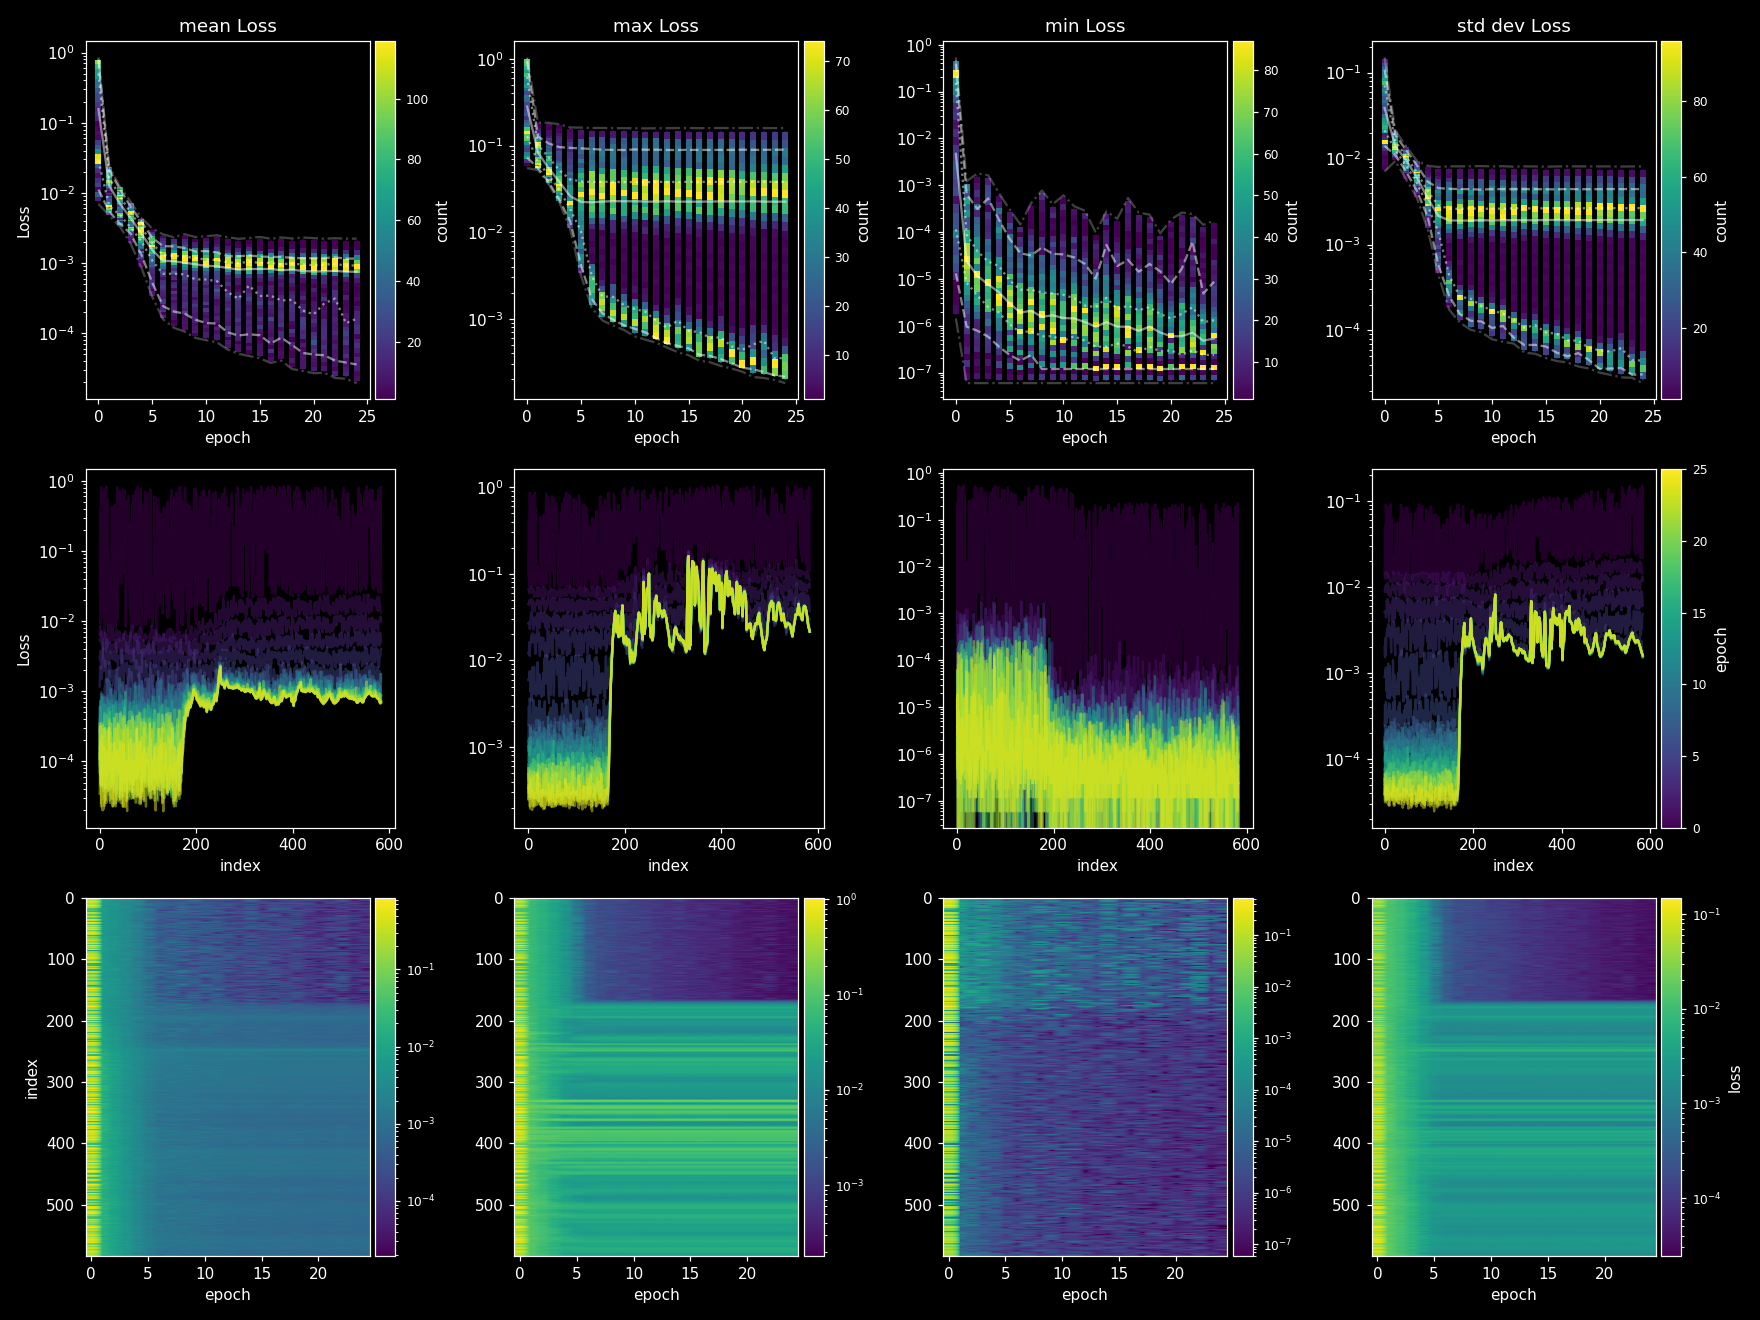

In [624]:
# plotLossesv2(trainingEpochLosses, logScale = True)
fig, axis = plotLossesv2(trainingEpochLosses, logScale = True)

fig.savefig('./trainingData/%s/training.png' % exportString, dpi = 300)

<IPython.core.display.Javascript object>


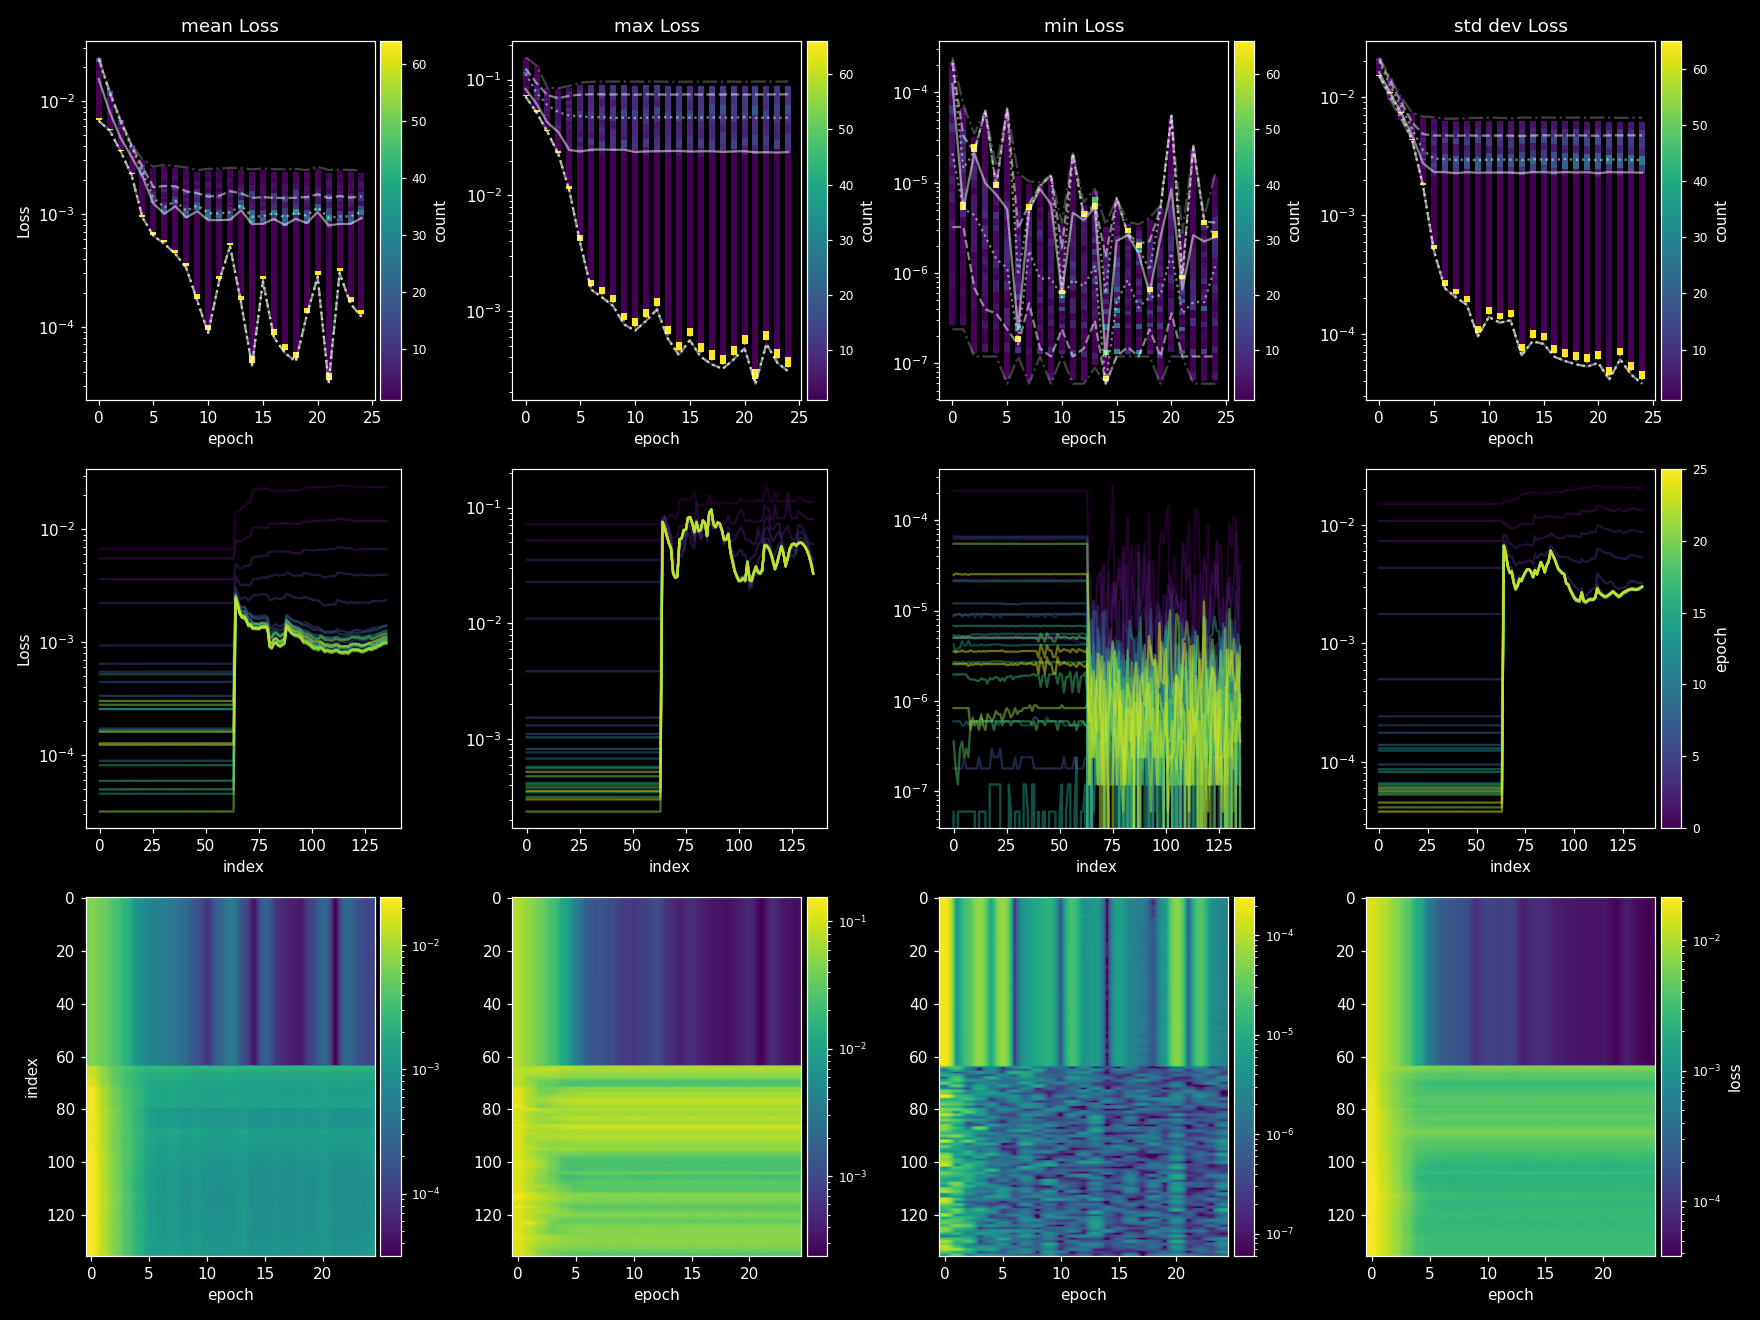

In [625]:

plotLossesv2(validationLosses, logScale = True)
fig.savefig('./trainingData/%s/validation.png' % exportString, dpi = 300)

In [626]:
import seaborn as sns
import pandas as pd

In [627]:
# debugPrint(epochLosses)

<IPython.core.display.Javascript object>


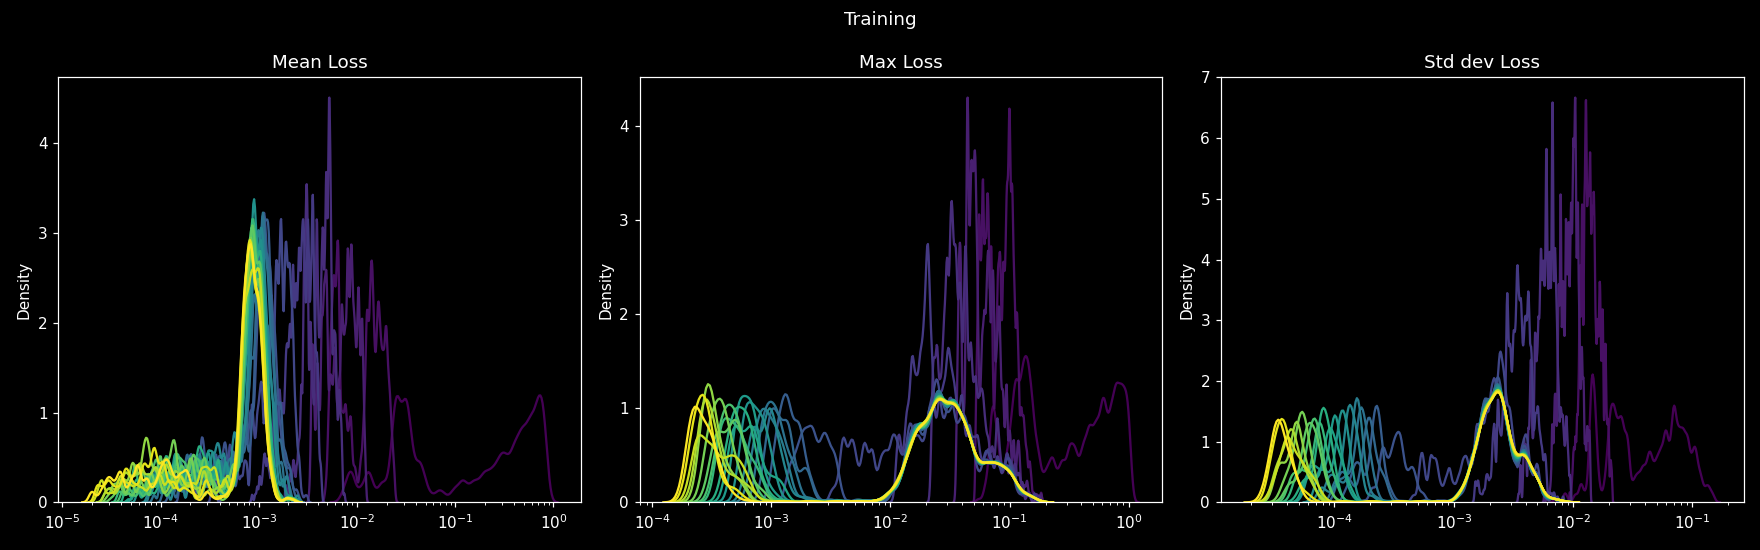

In [631]:
ei = -1
# epochLoss = {'mean': overallLosses[ei,:,0], 'max': overallLosses[ei,:,1], 'min': overallLosses[ei,:,1], 'stddev': overallLosses[ei,:,1]}
# epochLoss = pd.DataFrame(data = epochLoss)

overallLosses = np.vstack([np.expand_dims(np.vstack((np.mean(e[:,:,0], axis = 1), np.max(e[:,:,1], axis = 1), np.min(e[:,:,2], axis = 1) , np.mean(e[:,:,3], axis = 1))),2).T for e in trainingEpochLosses])
fig, axis = plt.subplots(1, 3, figsize=(16,5), sharex = False, sharey = False, squeeze = False)

fig.suptitle('Training')

plt.sca(axis[0,0])
axis[0,0].set_title('Mean Loss')
axis[0,1].set_title('Max Loss')
axis[0,2].set_title('Std dev Loss')

# debugPrint(epochLosses[0].shape)

# sns.kdeplot(epochLoss, x='mean', bw_adjust=.2, log_scale=True)

for ei in range(overallLosses.shape[0]):
#     epochLoss = {'mean': overallLosses[ei,:,0], 'max': overallLosses[ei,:,1], 'min': overallLosses[ei,:,1], 'stddev': overallLosses[ei,:,1]}
#     epochLoss = pd.DataFrame(data = epochLoss)
    plt.sca(axis[0,0])
    sns.kdeplot(overallLosses[ei,:,0], bw_adjust=.2, log_scale=True, label = 'epoch: %2d' % ei, c = cm.viridis(ei / ( overallLosses.shape[0] - 1)))
    plt.sca(axis[0,1])
    sns.kdeplot(overallLosses[ei,:,1], bw_adjust=.2, log_scale=True, label = 'epoch: %2d' % ei, c = cm.viridis(ei / ( overallLosses.shape[0] - 1)))
    plt.sca(axis[0,2])
    sns.kdeplot(overallLosses[ei,:,3], bw_adjust=.2, log_scale=True, label = 'epoch: %2d' % ei, c = cm.viridis(ei / ( overallLosses.shape[0] - 1)))

# axis[0,0].legend()

fig.tight_layout()

fig.savefig('./trainingData/%s/training_kde.png' % exportString, dpi = 300)

<IPython.core.display.Javascript object>


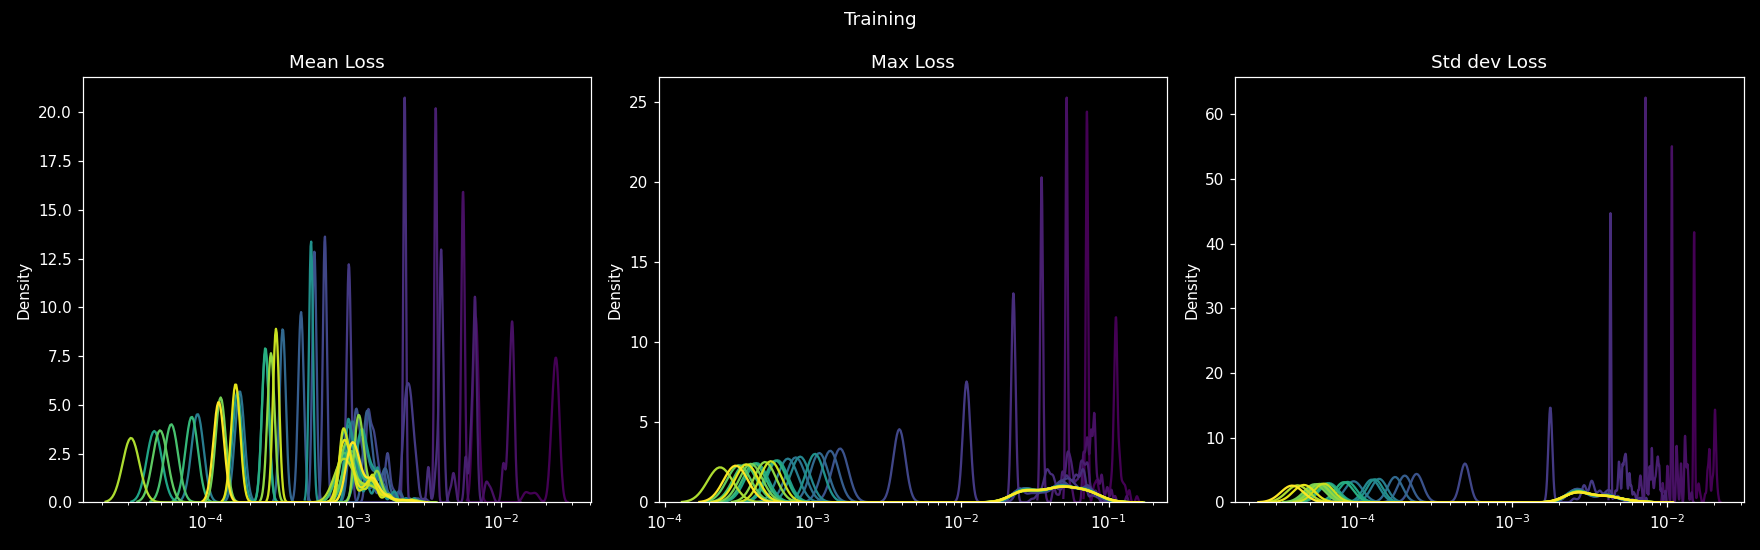

In [633]:
overallLosses = np.vstack([np.expand_dims(np.vstack((np.mean(e[:,:,0], axis = 1), np.max(e[:,:,1], axis = 1), np.min(e[:,:,2], axis = 1) , np.mean(e[:,:,3], axis = 1))),2).T for e in validationLosses])
fig, axis = plt.subplots(1, 3, figsize=(16,5), sharex = False, sharey = False, squeeze = False)

fig.suptitle('Training')

plt.sca(axis[0,0])
axis[0,0].set_title('Mean Loss')
axis[0,1].set_title('Max Loss')
axis[0,2].set_title('Std dev Loss')

# debugPrint(epochLosses[0].shape)

# sns.kdeplot(epochLoss, x='mean', bw_adjust=.2, log_scale=True)

for ei in range(overallLosses.shape[0]):
#     epochLoss = {'mean': overallLosses[ei,:,0], 'max': overallLosses[ei,:,1], 'min': overallLosses[ei,:,1], 'stddev': overallLosses[ei,:,1]}
#     epochLoss = pd.DataFrame(data = epochLoss)
    plt.sca(axis[0,0])
    sns.kdeplot(overallLosses[ei,:,0], bw_adjust=.2, log_scale=True, label = 'epoch: %2d' % ei, c = cm.viridis(ei / ( overallLosses.shape[0] - 1)))
    plt.sca(axis[0,1])
    sns.kdeplot(overallLosses[ei,:,1], bw_adjust=.2, log_scale=True, label = 'epoch: %2d' % ei, c = cm.viridis(ei / ( overallLosses.shape[0] - 1)))
    plt.sca(axis[0,2])
    sns.kdeplot(overallLosses[ei,:,3], bw_adjust=.2, log_scale=True, label = 'epoch: %2d' % ei, c = cm.viridis(ei / ( overallLosses.shape[0] - 1)))

# axis[0,0].legend()

fig.tight_layout()

fig.savefig('./trainingData/%s/validation_kde.png' % exportString, dpi = 300)

<IPython.core.display.Javascript object>


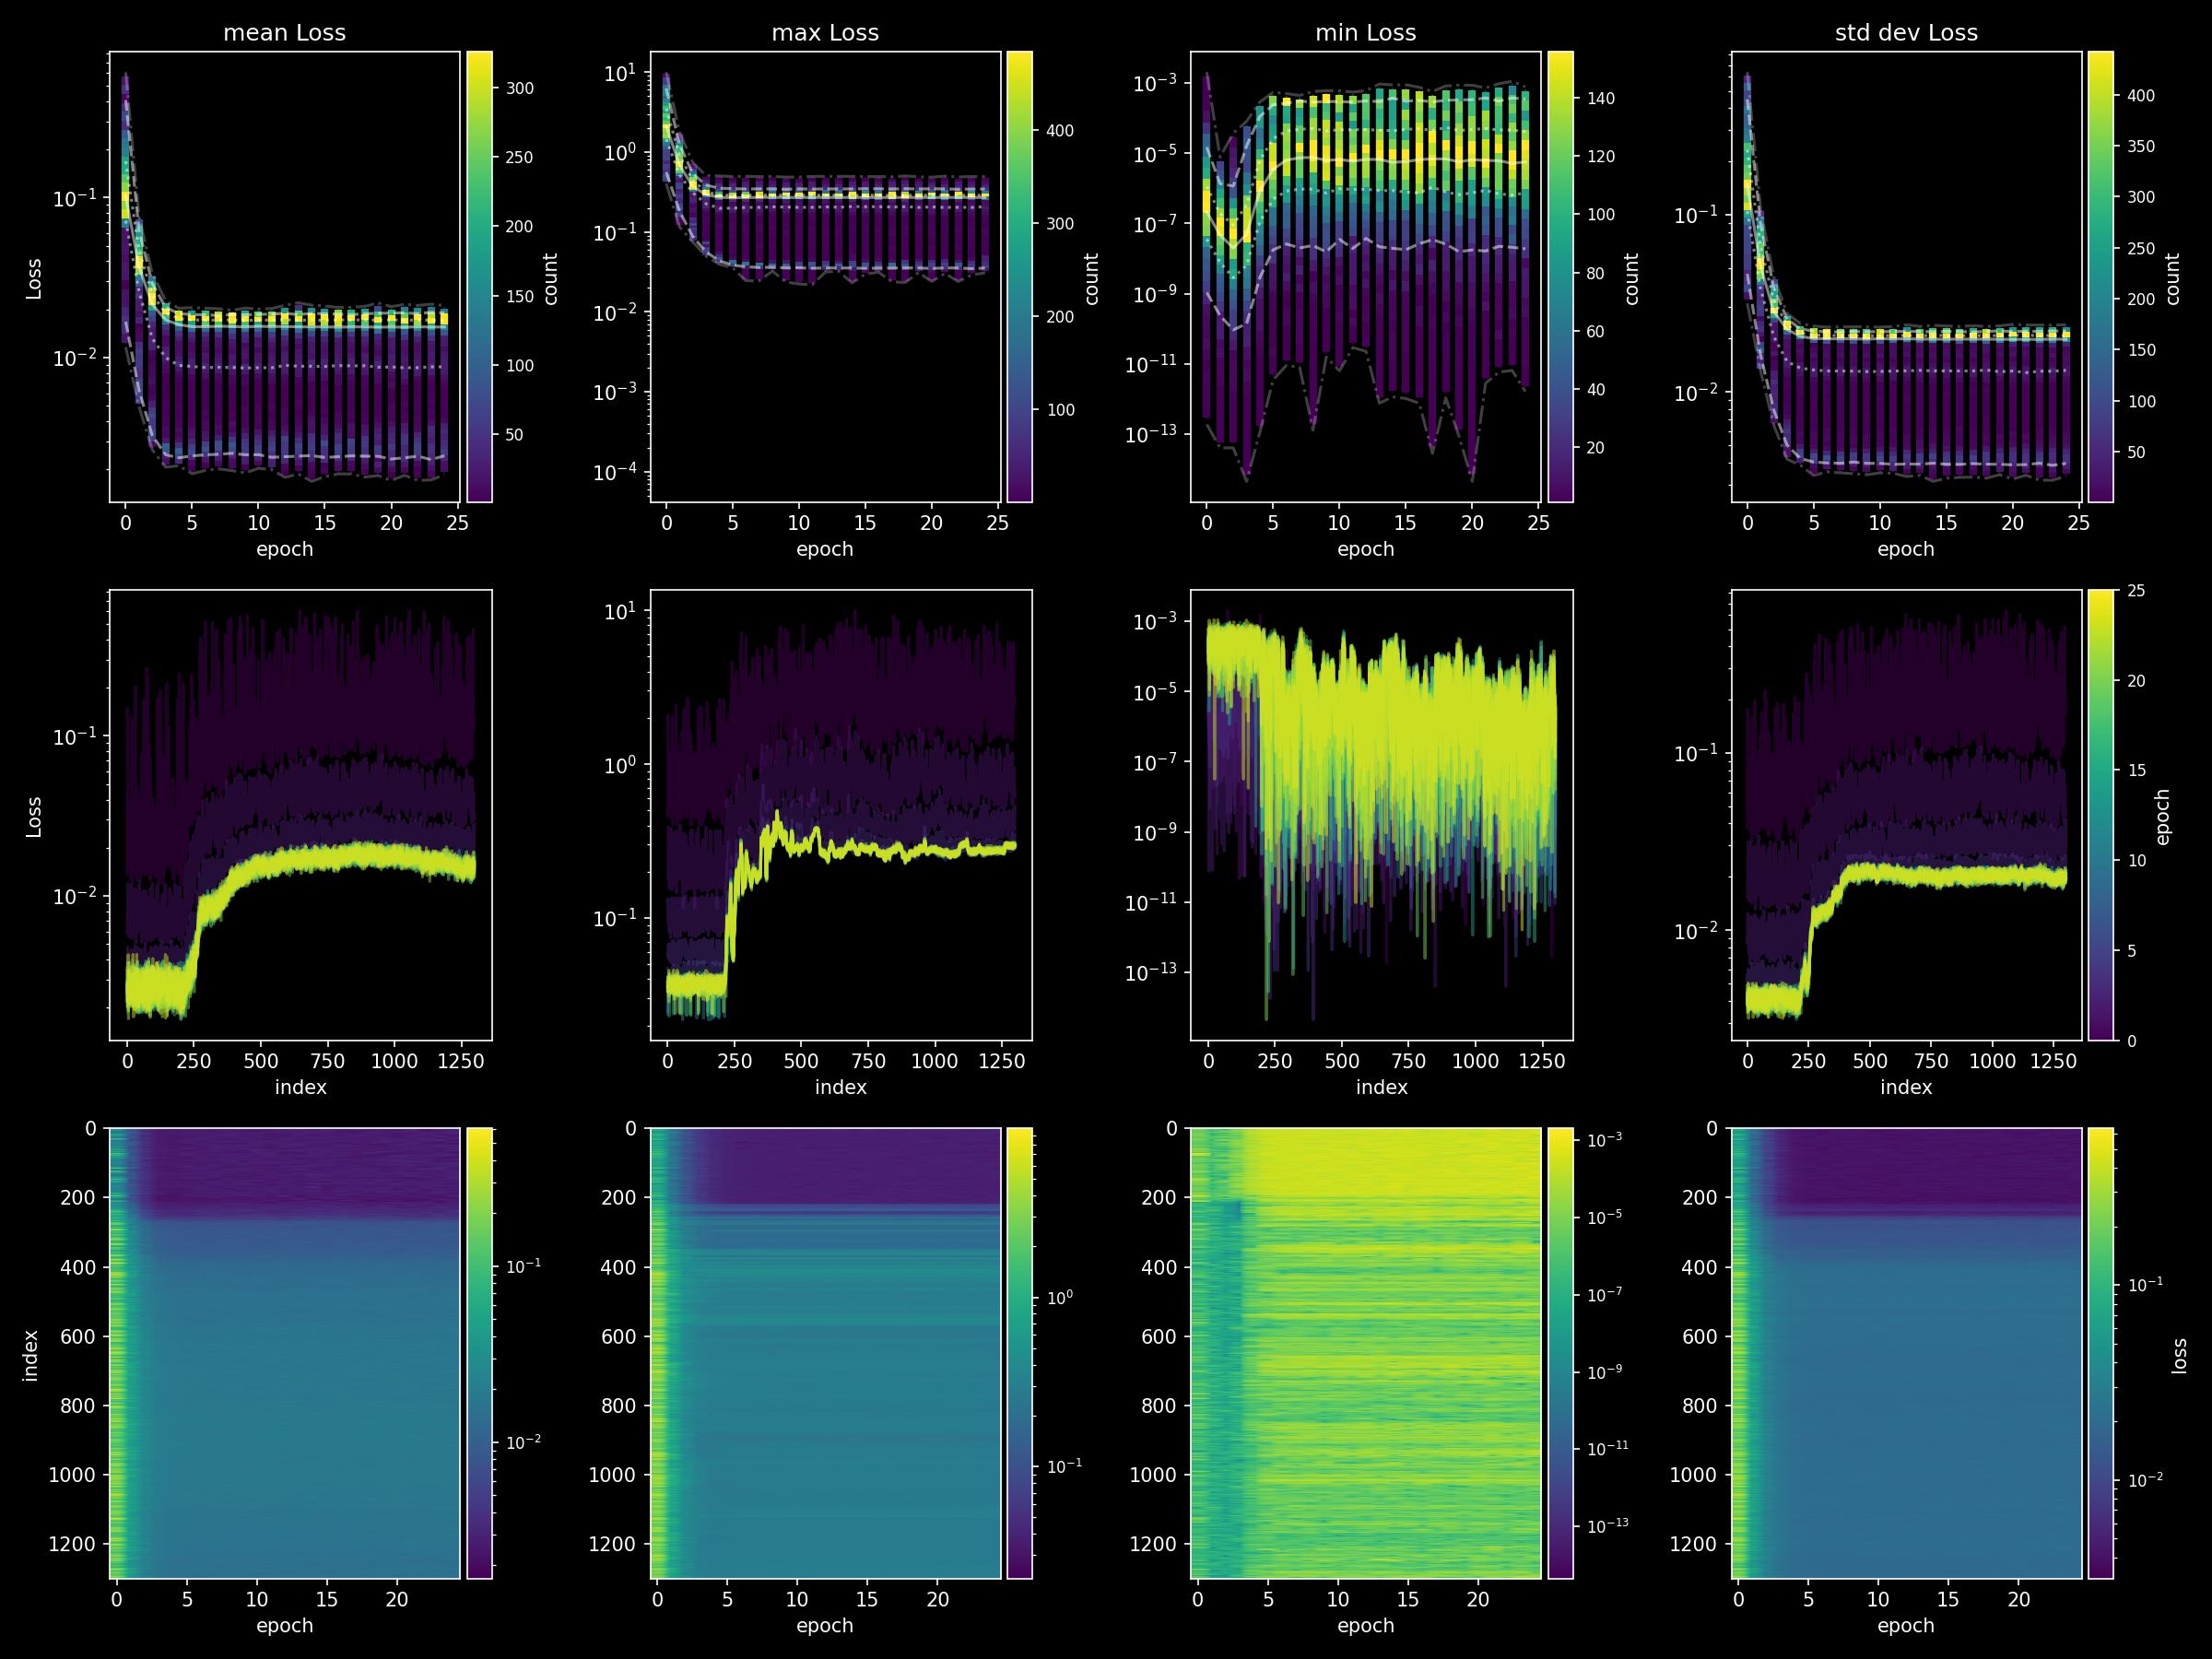

In [30]:
plotLossesv2(epochLosses)

modelOutput.shape [Size] = torch.Size([802, 1])


<IPython.core.display.Javascript object>


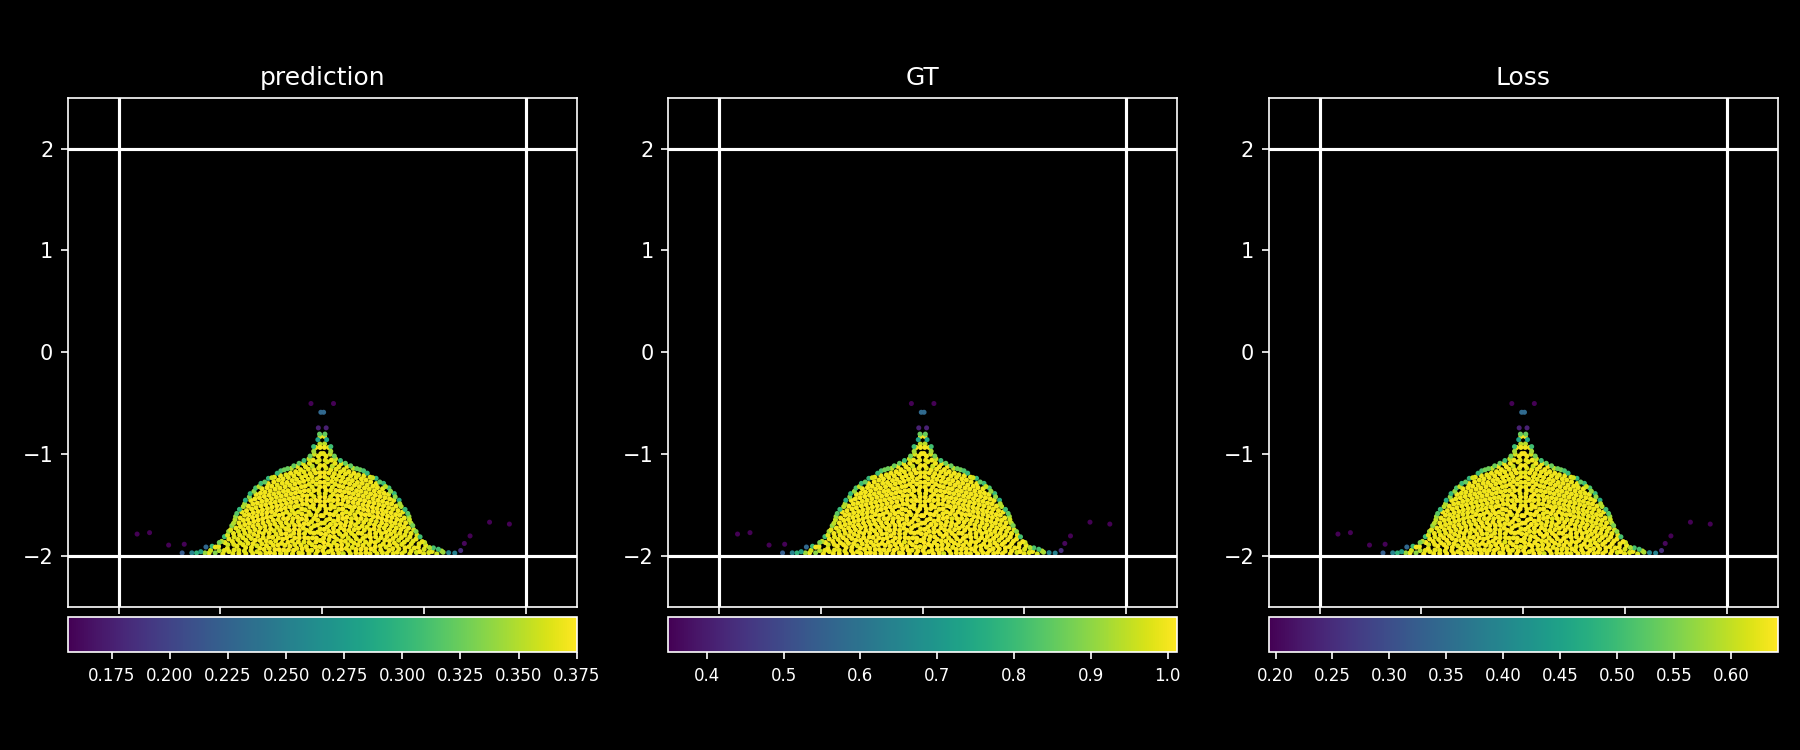

In [146]:
fileName, frameIndex, maxRollout = train_ds[len(train_ds)//2]
# frameIndex = 750
attributes, inputData, groundTruthData = loadFrame(simulationFiles[0], 400, 1 + np.arange(1))
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(inputData)
modelOutput = model(fluidPositions.to(device), boundaryPositions.to(device), fluidFeatures.to(device), boundaryFeatures.to(device), attributes['support'], None, None)

debugPrint(modelOutput.shape)

positions = inputData['fluidPosition'].to(device)

predictedPosition = inputData['fluidPosition'] + attributes['dt'] * inputData['fluidVelocity']
predictedVelocity = inputData['fluidVelocity'].to(device)# +  modelOutput

gt = groundTruthData[0].type(torch.float32).to(device)

loss = computeLoss(predictedPosition, predictedVelocity, gt, modelOutput)# (gt[:,-1:] - modelOutput) ** 2


# print(state['time'])

fig, axis = plt.subplots(1, 3, figsize=(12,5), sharex = False, sharey = False, squeeze = False)

axis[0,0].set_title('prediction')
x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()
v = modelOutput.detach().cpu().numpy()
# debugPrint(v)
predSC = axis[0,0].scatter(x,y,c = v,s=2)
axis[0,0].axis('equal')
axis[0,0].set_xlim(-2.5,2.5)
axis[0,0].set_ylim(-2.5,2.5)
axis[0,0].axvline(-2)
axis[0,0].axvline(2)
axis[0,0].axhline(-2)
axis[0,0].axhline(2)
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")

predCbar = fig.colorbar(predSC, cax=cax1,orientation='horizontal')
predCbar.ax.tick_params(labelsize=8) 


x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()

# v = (gt[:,-1:] - modelOutput) ** 2
v = (gt[:,-1:] )

axis[0,1].set_title('GT')
# sc = axis[1,0].scatter(x,y,c = v,s=0.25)
GTsc = axis[0,1].scatter(x,y,c = v.detach().cpu().numpy(), s= 2)
axis[0,1].axis('equal')
axis[0,1].set_xlim(-2.5,2.5)
axis[0,1].set_ylim(-2.5,2.5)
axis[0,1].axvline(-2)
axis[0,1].axvline(2)
axis[0,1].axhline(-2)
axis[0,1].axhline(2)
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
GTcbar = fig.colorbar(GTsc, cax=cax1,orientation='horizontal')
GTcbar.ax.tick_params(labelsize=8) 

fig.tight_layout()


axis[0,2].set_title('Loss')
# sc = axis[1,0].scatter(x,y,c = v,s=0.25)
GTsc = axis[0,2].scatter(x,y,c = loss.detach().cpu().numpy(), s= 2)
axis[0,2].axis('equal')
axis[0,2].set_xlim(-2.5,2.5)
axis[0,2].set_ylim(-2.5,2.5)
axis[0,2].axvline(-2)
axis[0,2].axvline(2)
axis[0,2].axhline(-2)
axis[0,2].axhline(2)
ax1_divider = make_axes_locatable(axis[0,2])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
GTcbar = fig.colorbar(GTsc, cax=cax1,orientation='horizontal')
GTcbar.ax.tick_params(labelsize=8) 

fig.tight_layout()



predictedPosition = inputData['fluidPosition'].to(device)
predictedVelocity = inputData['fluidVelocity'].to(device)


In [232]:
# debugPrint(fluidFeatures)

In [46]:
fileName, frameIndex, maxRollout = train_ds[len(train_ds)//2]
frameIndex = 750
attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 1 + np.arange(1))
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(inputData)
modelOutput = model(fluidPositions.to(device), boundaryPositions.to(device), fluidFeatures.to(device), boundaryFeatures.to(device), attributes['support'], None, None)


positions = inputData['fluidPosition'].to(device)

predictedPosition = inputData['fluidPosition'] + attributes['dt'] * inputData['fluidVelocity']
predictedVelocity = inputData['fluidVelocity'].to(device)# +  modelOutput

gt = groundTruthData[0].type(torch.float32).to(device)

loss = torch.linalg.norm(gt[:,2:] - predictedVelocity, dim = 1) ** 2


# print(state['time'])

fig, axis = plt.subplots(1, 2, figsize=(9,5), sharex = False, sharey = False, squeeze = False)

axis[0,0].set_title('prediction')
x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()
v = torch.linalg.norm(modelOutput,axis=1).detach().cpu().numpy()
# debugPrint(v)
predSC = axis[0,0].scatter(x,y,c = v,s=2)
axis[0,0].axis('equal')
axis[0,0].set_xlim(-2.5,2.5)
axis[0,0].set_ylim(-2.5,2.5)
axis[0,0].axvline(-2)
axis[0,0].axvline(2)
axis[0,0].axhline(-2)
axis[0,0].axhline(2)
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")

predCbar = fig.colorbar(predSC, cax=cax1,orientation='vertical')
predCbar.ax.tick_params(labelsize=8) 


x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()

v = torch.linalg.norm(gt[:,2:] - predictedVelocity,axis=1).detach().cpu().numpy()

axis[0,1].set_title('Loss')
# sc = axis[1,0].scatter(x,y,c = v,s=0.25)
GTsc = axis[0,1].scatter(x,y,c = v, s= 2)
axis[0,1].axis('equal')
axis[0,1].set_xlim(-2.5,2.5)
axis[0,1].set_ylim(-2.5,2.5)
axis[0,1].axvline(-2)
axis[0,1].axvline(2)
axis[0,1].axhline(-2)
axis[0,1].axhline(2)
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
GTcbar = fig.colorbar(GTsc, cax=cax1,orientation='vertical')
GTcbar.ax.tick_params(labelsize=8) 

fig.tight_layout()



predictedPosition = inputData['fluidPosition'].to(device)
predictedVelocity = inputData['fluidVelocity'].to(device)


RuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 1

In [141]:


# predictedPosition = inputData['fluidPosition'].to(device)
# predictedVelocity = inputData['fluidVelocity'].to(device)

for i in tqdm(range(128)):
#     debugPrint(i)
    fluidFeatures[:,1:3] = predictedVelocity
    
    modelOutput = model(fluidPositions.to(device), boundaryPositions.to(device), fluidFeatures.to(device), boundaryFeatures.to(device), attributes['support'], None, None)

    newPosition = predictedPosition + attributes['dt'] * predictedVelocity
    newVelocity = predictedVelocity +  modelOutput

    data = (torch.linalg.norm(modelOutput, dim = 1) ** 2).detach().cpu().numpy()
    data = (torch.linalg.norm(newVelocity, dim = 1) ** 2).detach().cpu().numpy()
    predCbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
    predSC.set_offsets(newPosition.detach().cpu().numpy())
    predSC.set_array(data)

    attributes, inputData, groundTruthData = loadFrame(fileName,frameIndex + 1)
    data = (torch.linalg.norm(inputData['fluidPosition'].to(device) - newPosition, dim = 1) ** 2).detach().cpu().numpy()
    GTcbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
    GTsc.set_offsets(inputData['fluidPosition'].detach().cpu().numpy())
    GTsc.set_array(data)

    predictedPosition = newPosition
    predictedVelocity = newVelocity
    fig.canvas.draw()
    fig.canvas.flush_events()

    frameIndex = frameIndex + 1
# for i in range(8):
#     modelOutput = model(predictedPosition, predictedVelocity, predictedPosition, attrs['support'], None, None)

#     predictedPosition = inputData['fluidPosition'] + attrs['dt'] * inputData['fluidVelocity']
#     predictedVelocity = inputData['fluidVelocity'].to(device) +  modelOutput

#     gt = gtData[0].type(torch.float32).to(device)
    
    
    

  0%|          | 0/128 [00:00<?, ?it/s]